In [1]:
#imports and mode management 

import rospy
import jupyros
from robot_control_final_assignment.srv import Mode
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import ipywidgets as widgets

def mode_callback(mode): #management of mode closing and call
    print("Please close any window opened by previous modes")
    rospy.wait_for_service('mode')
    try:
        mode_client = rospy.ServiceProxy('mode', Mode)
        response = mode_client(mode)
        return True
    except rospy.ServiceException as e:
        return False

In [2]:
#button to control modes

#button definition
b1 = Button(description='move_base control',
            layout=Layout(width='auto', grid_area='b1'),
            style=ButtonStyle(button_color='lightblue'))
b2 = Button(description='keyboard control',
            layout=Layout(width='auto', align='center', grid_area='b2'),
            style=ButtonStyle(button_color='moccasin'))
b3 = Button(description='keyboard control with help',
            layout=Layout(width='auto', grid_area='b3'),
            style=ButtonStyle(button_color='salmon'))

output = widgets.Output()

display(HBox([b1,b2,b3]), output)

#button activation
def on_button_clicked(b):
    if b == b1:
        with output:
            if mode_callback(1):
                print("move_base mode activated")
    if b == b2:
        with output:
            if mode_callback(2):
                print("keyboard mode activated")
    if b == b3:
        with output:
            if mode_callback(3):
                print("keyboard_with_help mode activated")
            


b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)
b3.on_click(on_button_clicked)



Output()

In [3]:
from IPython.display import clear_output
from sensor_msgs.msg import LaserScan
import jupyros

range_min = 0.0
angle_min = 0.0
show_rate = 10

out2 = widgets.Output()

def scan_cb(msg):
    global range_min
    global angle_min
    global out2
    global show_rate
    #get the minimum distance and angle from LaserScan
    if (msg.range_min != range_min) or (msg.angle_min != angle_min):
        if show_rate == 10:#show rates ensures that values are only shown every second
            range_min = msg.range_min
            angle_min = msg.angle_min
            with out2:
                out2.clear_output()
                print(f"minimum distance is {range_min}, minimum angle is {angle_min}")
            out2
            show_rate = 0
        else:
            show_rate += 1


rospy.init_node('jupyter_node')
jupyros.subscribe('/scan_general', LaserScan, scan_cb)


Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


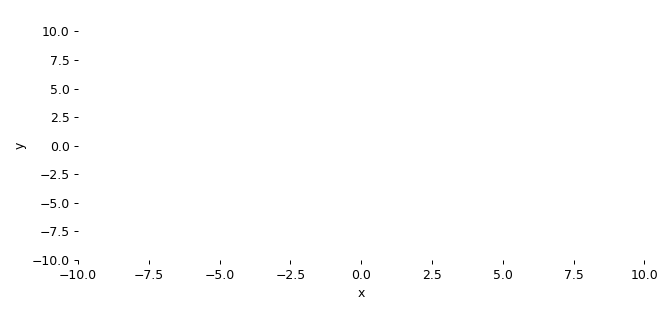

Removing previous callback, only one redirection possible right now


In [35]:
%matplotlib notebook

import matplotlib.pyplot as plt
import rospy
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_callback(self, msg):#get x and y positions
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
vis = Visualiser()
jupyros.subscribe('/odom', Odometry, vis.odom_callback)#get odometry values
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)

#plot labeling
plt.xlabel("x")
plt.ylabel("y")
plt.title("Estimated position")
plt.show(block=True)

<IPython.core.display.Javascript object>


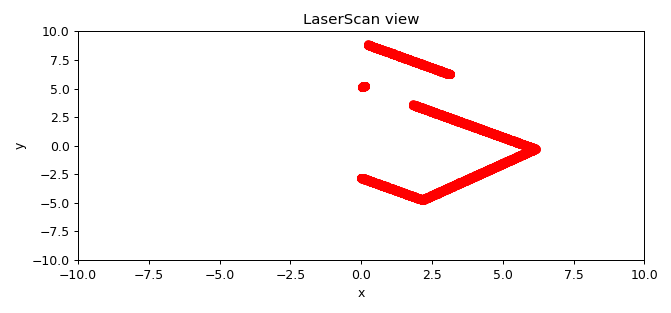

Removing previous callback, only one redirection possible right now


In [37]:
class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_callback(self, msg):
        print(vis.x_data,vis.y_data)
        increment = (msg.angle_max - msg.angle_min)/len(msg.intensities) 
        
        #convert laserscan message in pointcloud (x and y coordinates)
        for i in range(len(msg.ranges)):
            x = msg.ranges[i]*np.cos(msg.angle_min + increment*i)
            y = msg.ranges[i]*np.sin(msg.angle_min + increment*i)
            self.y_data.append(y)
            self.x_data.append(x)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        
        return self.ln
    
vis = Visualiser()
jupyros.subscribe('/scan_general', LaserScan, vis.odom_callback)#get laserscan as seen by robot
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)

#plot labeling
plt.xlabel("x")
plt.ylabel("y")
plt.title("LaserScan view")
plt.show(block=True)

<IPython.core.display.Javascript object>


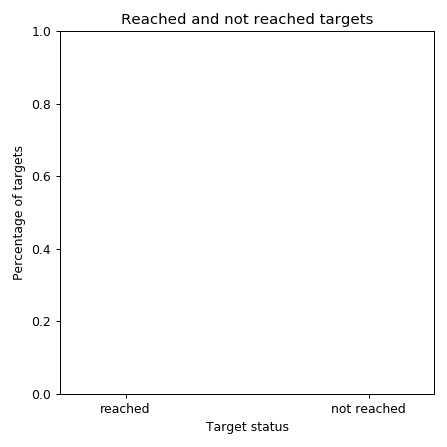

Removing previous callback, only one redirection possible right now


In [36]:
import numpy as np
from std_msgs.msg import Bool
from matplotlib import animation as animation, pyplot as plt, cm

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(0, 1)

#plot init and definition
data = [0, 0] 
num_tot = 0
data_num = [0,0]
status = ['reached', 'not reached']
bars = plt.bar(status, data, color ='maroon',
        width = 0.4)

def odom_callback(msg):
    global data
    global data_num
    global num_tot
    num_tot = num_tot + 1
    #get booolean from published topic
    if (msg.data == True):
        data_num[0] = (data_num[0] + 1)
    else:
        data_num[1] = (data_num[1] + 1)
    #get frequencies for reached and non reached targets
    data[0] = data_num[0]/num_tot
    data[1] = data_num[1]/num_tot
            
jupyros.subscribe('/reached_targets', Bool, odom_callback)


def animate(frame):
    #get new data values
   global bars
   index = data[frame]
   bars[frame].set_height(index)

ani = animation.FuncAnimation(fig, animate, frames=len(data))

#plot labeling
plt.xlabel("Target status")
plt.ylabel("Percentage of targets")
plt.title("Reached and not reached targets")

plt.show(block = True)